### Lab | SQL Queries 9
Instructions

We will be trying to predict if a customer will be renting a film this month based on their previous activity and other details. We will first construct a table with:

1. Customer ID
2. City
3. Most rented film category
4. Total films rented
5. Total money spent
6. How many films rented last month
+
7. yes/no whether the customer rented this month - TARGET 

and try to predict if he will be renting this month. 
Use date range (15/05/2005 - 30/05/2005) for last month and (15/06/2005 - 30/06/2005) for this month.


In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()


········


In [2]:
import numpy as np

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [4]:
#address sakila database 
engine.execute("USE sakila")

We'll be creating the table column by column


#### 1. Customer_id + city

In [5]:
query = 'select c.customer_id, ct.city from customer as c \
join address on c.address_id = address.address_id \
join city as ct on ct.city_id = address.city_id'

data_customer_city = pd.read_sql_query(query, engine)
data_customer_city.head()

,customer_id,city
0,1,Sasebo
1,2,San Bernardino
2,3,Athenai
3,4,Myingyan
4,5,Nantou


In [6]:
data_customer_city.shape

(584, 2)

possibly not all the customers have address

#### 2. Customer_id + total amount spent

In [7]:
query = 'select customer_id, sum(amount) as amount_spent from payment \
group by customer_id'

data_customer_spent = pd.read_sql_query(query, engine)
data_customer_spent.head()


,customer_id,amount_spent
0,1,118.68
1,2,128.73
2,3,135.74
3,4,81.78
4,5,144.62


In [8]:
data_customer_spent.shape

(599, 2)

#### 3. Customer_id + total films rented 



In [9]:
query = 'select customer_id, count(inventory_id) as films_rented from rental \
group by customer_id'

data_customer_films_total = pd.read_sql_query(query, engine)
data_customer_films_total.head()

,customer_id,films_rented
0,1,32
1,2,27
2,3,26
3,4,22
4,5,38


In [10]:
data_customer_films_total.shape

(599, 2)

#### 4. Customer_id + How many films rented last month

In [11]:
# last month - 25/05/2005 - 24/06/2005

query = 'select c.customer_id, count(r.rental_id) as films_rented_lm from rental as r \
right outer join customer as c on \
r.customer_id = c.customer_id and r.rental_date >= 20050515 and r.rental_date <= 20050530 \
group by c.customer_id order by c.customer_id'

data_customer_films = pd.read_sql_query(query, engine)
data_customer_films.head()


,customer_id,films_rented_lm
0,1,2
1,2,1
2,3,2
3,4,0
4,5,1


In [12]:
data_customer_films.shape

(584, 2)

not everyone rented that month - there will be 0 for the other customer id's

#### 5. Most rented film category

In [13]:
query = 'select customer_id, category from \
(select r.customer_id as customer_id, ct.name as category, count(ct.name), \
dense_rank() over (partition by r.customer_id order by count(ct.name) desc) as ranking \
from rental as r \
join inventory as i on r.inventory_id = i.inventory_id \
join film_category as fc on fc.film_id = i.film_id \
join category as ct on ct.category_id = fc.category_id \
group by ct.name, r.customer_id \
order by r.customer_id, count(ct.name) desc) as magic_table \
where ranking = 1 \
order by customer_id'

data_customer_category = pd.read_sql_query(query, engine)
data_customer_category

#can't use yet as there's repeated data (ties in ranking)

,customer_id,category
0,1,Classics
1,2,Sports
2,3,Action
3,4,Horror
4,5,Classics
...,...,...
994,598,Comedy
995,598,Foreign
996,599,Sci-Fi
997,599,Horror


#### Create a dataframe, similar to OHE, but if we have a tie between most rented categories - we will have several '1' in the customer_id row, and the rest 0 

In [14]:
#getting list of categories that are most rented by customers - future column names 
column_a = list(data_customer_category['category'].unique())
categories = column_a
categories

['Classics',
 'Sports',
 'Action',
 'Horror',
 'Drama',
 'Animation',
 'Foreign',
 'Travel',
 'Games',
 'Documentary',
 'Children',
 'New',
 'Sci-Fi',
 'Family',
 'Comedy',
 'Music']

In [15]:
#renaming as easier to use
x = data_customer_category 



def magic(x, y):
    """
    function will return z - an array of (customer_id - 1) 
    that mostly rent a category y = 'category name'
    (customer_id - 1) so we get an array pf indexes to use in the future dataframe
    """
    z=[]
    for i in range(len(x)):
        if x.category[i] == y:
            z.append(x.customer_id[i]-1) 

    return z

In [16]:
# creating a list of list that contain indexes of cells where we need to put '1'
# cat_index[0] - for category [0] i.e. Classics

cat_index = []

for i in range(len(categories)):
    cat_index.append(magic(x, categories[i]))

In [17]:
#creating an empty dataframe
a = pd.DataFrame(columns = ['customer_id'] + column_a)
a.head()

,customer_id,Classics,Sports,Action,Horror,Drama,Animation,Foreign,Travel,Games,Documentary,Children,New,Sci-Fi,Family,Comedy,Music


In [18]:
a.loc[:] = 0
a.customer_id = list(data_customer_category['customer_id'].unique())
a.loc[:, column_a] = 0
a

,customer_id,Classics,Sports,Action,Horror,Drama,Animation,Foreign,Travel,Games,Documentary,Children,New,Sci-Fi,Family,Comedy,Music
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,595,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
595,596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
596,597,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
597,598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
#populating with 1s
for i in range(len(categories)):
    a.loc[cat_index[i], categories[i]] = 1

data_customer_category = a
a


,customer_id,Classics,Sports,Action,Horror,Drama,Animation,Foreign,Travel,Games,Documentary,Children,New,Sci-Fi,Family,Comedy,Music
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,595,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
595,596,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
596,597,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
597,598,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


#### 6. YES/NO rented this month

In [20]:
# 25/06/2005 - 24/07/2005 - as this month 

query = 'select customer_id, if(films_rented > 1, "YES", "NO") as rent_this_month from \
(select c.customer_id as customer_id, count(r.rental_id) as films_rented \
from rental as r \
right outer join customer as c on \
r.customer_id = c.customer_id and \
r.rental_date >= 20050615 and r.rental_date <= 20050630 \
group by c.customer_id \
order by c.customer_id) as magic_table'


data_next_month = pd.read_sql_query(query, engine)
data_next_month.head()


,customer_id,rent_this_month
0,1,YES
1,2,NO
2,3,YES
3,4,YES
4,5,YES


In [21]:
data_next_month.shape

(584, 2)

#### JOINING DATAFRAMES

In [22]:
#merge seems to only work 2 dataframes at a time => 

In [42]:
data1 = pd.merge(data_customer_city, data_customer_films_total, on = 'customer_id')

data2 = pd.merge(data_customer_spent, data_customer_films, on = 'customer_id')

data3 = pd.merge(data1, data2, how = 'inner', on = 'customer_id')

data4 = pd.merge(data3, data_customer_category, how = 'inner', on = 'customer_id')

data = pd.merge(data4, data_next_month, on = 'customer_id')

data


,customer_id,city,films_rented,amount_spent,films_rented_lm,Classics,Sports,Action,Horror,Drama,...,Travel,Games,Documentary,Children,New,Sci-Fi,Family,Comedy,Music,rent_this_month
0,1,Sasebo,32,118.68,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,YES
1,2,San Bernardino,27,128.73,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NO
2,3,Athenai,26,135.74,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,YES
3,4,Myingyan,22,81.78,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,YES
4,5,Nantou,38,144.62,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,595,Jinzhou,30,117.70,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,NO
580,596,Patras,28,96.72,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,YES
581,597,Sullana,25,99.75,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,YES
582,598,Lausanne,22,83.78,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,NO


#### DATA EXPLORATION

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

In [44]:
print("The dataframe has {} rows and {} columns".format(data.shape[0],data.shape[1]))
print()
print("The data types of each column of the dataframe are:")
print(data.dtypes)
print()



The dataframe has 584 rows and 22 columns

The data types of each column of the dataframe are:
customer_id          int64
city                object
films_rented         int64
amount_spent       float64
films_rented_lm      int64
Classics             int64
Sports               int64
Action               int64
Horror               int64
Drama                int64
Animation            int64
Foreign              int64
Travel               int64
Games                int64
Documentary          int64
Children             int64
New                  int64
Sci-Fi               int64
Family               int64
Comedy               int64
Music                int64
rent_this_month     object
dtype: object



In [45]:
data.describe()

,customer_id,films_rented,amount_spent,films_rented_lm,Classics,Sports,Action,Horror,Drama,Animation,Foreign,Travel,Games,Documentary,Children,New,Sci-Fi,Family,Comedy,Music
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,298.979452,26.782534,112.593425,1.395548,0.090753,0.154110,0.136986,0.070205,0.111301,0.155822,0.125000,0.066781,0.094178,0.114726,0.065068,0.085616,0.148973,0.106164,0.063356,0.068493
std,172.756244,5.091846,25.398618,1.200077,0.287504,0.361363,0.344128,0.255712,0.314775,0.362997,0.331002,0.249856,0.292327,0.318964,0.246858,0.280037,0.356367,0.308312,0.243811,0.252807
min,1.000000,12.000000,50.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149.750000,23.000000,94.787500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,298.500000,26.000000,110.725000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,448.250000,30.000000,128.712500,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,599.000000,46.000000,221.550000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Checking NA values

In [46]:
print("The number of NA's in the dataframe is: ")
print(data.isna().sum())
print()

The number of NA's in the dataframe is: 
customer_id        0
city               0
films_rented       0
amount_spent       0
films_rented_lm    0
Classics           0
Sports             0
Action             0
Horror             0
Drama              0
Animation          0
Foreign            0
Travel             0
Games              0
Documentary        0
Children           0
New                0
Sci-Fi             0
Family             0
Comedy             0
Music              0
rent_this_month    0
dtype: int64



#### Categorical columns

The categorical columns are:  ['city', 'rent_this_month']

Frequency analysis of column:  city

Frequency analysis of column:  rent_this_month



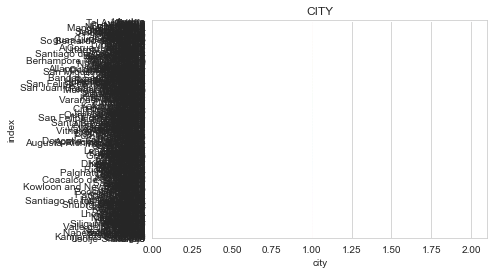

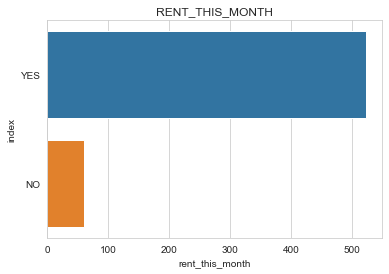

<Figure size 432x288 with 0 Axes>

In [47]:
#checking categorical columns


cols_cat = list(data.select_dtypes(include=['object']).columns)

print("The categorical columns are: ",cols_cat)
print("========================================")
print()

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = data[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print()

In [48]:
#unique cities:
len(data['city'].unique())

582

Dropping the columns as almos as many as customer_id and won't make the difference

In [49]:
data['city'].value_counts()

London               2
Aurora               2
Udaipur              1
Toulon               1
Tel Aviv-Jaffa       1
                    ..
Tarlac               1
Erlangen             1
Lublin               1
Sasebo               1
Usolje-Sibirskoje    1
Name: city, Length: 582, dtype: int64

In [50]:
data_copy = data.copy()

data = data.drop(['customer_id', 'city'], axis = 1)
data

,films_rented,amount_spent,films_rented_lm,Classics,Sports,Action,Horror,Drama,Animation,Foreign,Travel,Games,Documentary,Children,New,Sci-Fi,Family,Comedy,Music,rent_this_month
0,32,118.68,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YES
1,27,128.73,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NO
2,26,135.74,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,YES
3,22,81.78,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,YES
4,38,144.62,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,30,117.70,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NO
580,28,96.72,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YES
581,25,99.75,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,YES
582,22,83.78,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,NO


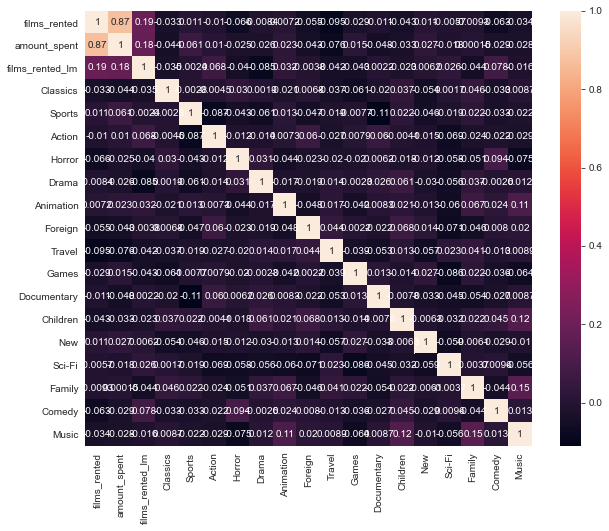

In [51]:
#numerical data correlations
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

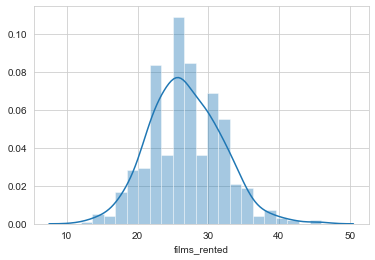

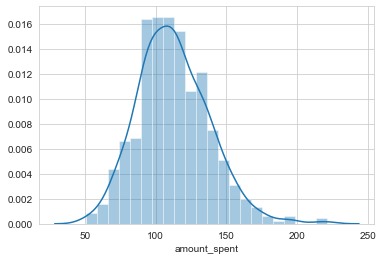

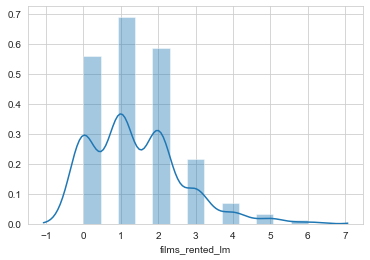

In [52]:
#for linear model we would have dropped l_amounts/payment 
#for this model - we don't mind 
sns.distplot(data['films_rented'])
plt.show()
sns.distplot(data['amount_spent'])
plt.show()
sns.distplot(data['films_rented_lm'])
plt.show()




#### SCALING DATASET

In [53]:
y = data['rent_this_month']
X = data.drop(['rent_this_month'], axis = 1)

In [54]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(X)
x_standarized = transformer.transform(X)
x_standarized = pd.DataFrame(x_standarized)
X = x_standarized

#### MODEL

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19698)

In [56]:
#training the model for logistic regression 
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

In [57]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(X_test)

#### EVALUATION

The accuracy of the model on test set is: 0.93 


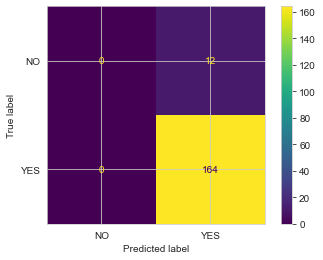

0.0


In [58]:
#check how many matches between prediction and actual results 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

from sklearn.metrics import cohen_kappa_score
print (cohen_kappa_score(y_test, predictions))